# MRI

Example MRI reconstruction with deep decoder and l1 minimization

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr
import h5py

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')

## Load MRI images

collected  199  images


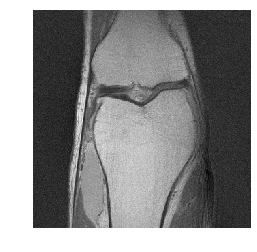

In [3]:
def crop_center(img,cropx,cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        return img[starty:starty+cropy,startx:startx+cropx]
    if len(img.shape) == 3:
        return img[0,starty:starty+cropy,startx:startx+cropx]

def get_mri_imgs(path = './fastMRI-master/singlecoil_val/'):
    data = []
    imgnames = [f for f in listdir(path) if isfile(join(path, f))]
    for imgname in imgnames:
        filename = path + imgname#'./fastMRI-master/singlecoil_val/file1001077.h5'
        f = h5py.File(filename, 'r')
        
        #nu = int(f['kspace'].shape[0] / 2) # get a middle slice so there is content
        nu = int(f['kspace'].shape[0] / 2) # get a middle slice so there is content
        ksp = f['kspace'][nu]  # get full kspace measurement

        ksp = crop_center(ksp,320,640)
        
        # l2 reconstruction from full kspace measurement
        img_l2 = sp.ifft(ksp)
        #img_l2 = f['reconstruction_esc'][nu]

        rang = np.max(np.abs(img_l2)) #- np.min(np.abs(img_l2))
        img_l2 /= rang
        ksp /= rang
        data += [(ksp, np.real(img_l2))]
    print("collected ", len(data), " images")
    return data

data = get_mri_imgs()

# plot example image
(ksp_np,img_ref) = data[20]
plt.imshow(crop_center(img_ref,320,320),cmap='gray')
plt.axis('off')
plt.show()

## Undersample, define mask

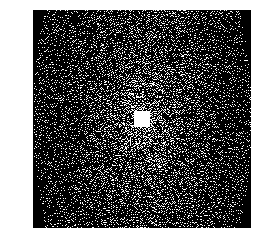

In [4]:
# Undersample
accel = 8  # Acceleration factor

wshape = img_ref.shape # (640,320)
mask2d = mr.poisson( wshape , accel=accel, calib=[24, 24]).astype(float)
mask = Variable( torch.zeros( (1,1,) + wshape + (2,) ) ).type(dtype)
mask[0,:,:,:,0] = np_to_var(mask2d)
mask[0,:,:,:,1] = np_to_var(mask2d)

maskcrop = crop_center( mask2d ,320,320)
savefig('mask.png',maskcrop)

## Forward model and least squares reconstruction

In [ ]:
# forward model
def forwardm(img_var,mask=mask):
    fimg = Variable( torch.zeros(img_var.shape + (2,) ) ).type(dtype)
    fimg[:,:,:,:,0] = img_var
    Fimg = transforms.fft2(fimg)
    return Fimg*mask

img_var = np_to_var( np.array([img_ref]) )

out = forwardm(img_var)

# least squares reconstruction
def lsreconstruction(measurement):
    fimg = transforms.ifft2(measurement)
    return fimg[:,:,:,:,0]

def ksp_np_to_measurement(ksp_np):
    Fimg = Variable( torch.zeros( (1,1,) + ksp_np.shape + (2,) ) ).type(dtype)
    Fimg[:,:,:,:,0] = np_to_var(np.real(ksp_np))
    Fimg[:,:,:,:,1] = np_to_var(np.imag(ksp_np))
    return Fimg
    
measurement = ksp_np_to_measurement(ksp_np)*mask

lsimg_var = lsreconstruction(measurement)

## L1 wavelet reconstruction

In [ ]:
def get_l1wav(ksp_np,img_np,from_ksp=False):
    if from_ksp:
        y = ksp_np
    else:
        mask2d = mr.poisson( img_np.shape , accel=accel, calib=[24, 24]).astype(float)
        y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(ksp_np.shape)
    P = sp.linop.Multiply(ksp_np.shape, mask2d)
    A = P * F

    lamda = 0.01 # best of 0.001, 0.01, 0.05, 0.005
    W = sp.linop.Wavelet(ksp_np.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)

    img_l1wav = sp.app.LinearLeastSquares(A, y, proxg=proxg).run()
    return img_l1wav.astype(float)

img_l1wav = get_l1wav(ksp_np,img_ref)

LinearLeastSquares: 100%|██████████| 100/100 [00:04<00:00, 22.42it/s, resid=9.67E-03]


## Total variation

In [ ]:
def get_TV(img_np):
    mask2d = mr.poisson( img_np.shape , accel=accel, calib=[24, 24]).astype(float)
    y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(ksp_np.shape)
    P = sp.linop.Multiply(ksp_np.shape, mask2d)
    A = P * F

    lamda = 0.02 # best of: 0.001, 0.005, 0.01, 0.02, 0.05
    #W = sp.linop.Wavelet(ksp_np.shape)
    #proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    G = sp.linop.Gradient(img_np.shape)
    proxg = sp.prox.L1Reg(G.oshape, lamda)
    
    img_TV = sp.app.LinearLeastSquares(A, y, proxg=proxg,G=G).run()
    return img_TV.astype(float)

img_TV = get_TV(img_ref)
print(img_TV.shape)

LinearLeastSquares: 100%|██████████| 100/100 [00:04<00:00, 22.13it/s, resid=5.25E-02]

(640, 320)


### DD reconstruction

In [ ]:
def dd_recovery(measurement,img_var,k=128):
    measurement = forwardm(img_var).type(dtype)
    num_channels = [k]*5
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,num_iter=15000,LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net,apply_f = forwardm,img_clean_var=img_var.type(dtype),
                        upsample_mode='bilinear',
                        )
    out_img_var = net( ni.type(dtype) )
    return out_img_var

out_img_var128 = dd_recovery(measurement,img_var)
out_img_var256 = dd_recovery(measurement,img_var,256)

input shape:  [1, 128, 20, 10]
optimize with adam 0.005


## Get example reconstructions

In [ ]:
def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')
       
def addimg(ax,name,img_np):
    ax.imshow(img_np,cmap='gray')
    ax.set_title( name + ", SNR: %.2f" % psnr(img_ref,img_np) ) 
    ax.axis('off')
    return ax

out_img_np128 = crop_center( out_img_var128.data.cpu().numpy()[0] ,320,320)
out_img_np256 = crop_center( out_img_var256.data.cpu().numpy()[0] ,320,320)
img_ls_np = crop_center( lsimg_var.data.cpu().numpy()[0] ,320,320)
img_ref = crop_center(img_ref ,320,320)
img_l1wav = crop_center(img_l1wav ,320,320)
img_TV = crop_center(img_TV ,320,320)
    
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure

ax1 = fig.add_subplot(231)
ax1 = addimg(ax1,'Original image',img_ref)

ax2 = fig.add_subplot(232)
ax2 = addimg(ax2,'Least-squares',img_ls_np)

ax3 = fig.add_subplot(233)
ax3 = addimg(ax3,'l1 min',img_l1wav)

ax4 = fig.add_subplot(234)
ax4 = addimg(ax4,'TV',img_TV)

ax5 = fig.add_subplot(235)
ax5 = addimg(ax5,'DD128',out_img_np128)

ax6 = fig.add_subplot(236)
ax6 = addimg(ax6,'DD256',out_img_np256)

plt.show()

#plot_results(img_ref_,img_ls_np,img_l1wav,img_TV,out_img_np)

In [ ]:
def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')
    
savefig('mri_orig' + str(accel) + '.png',img_ref)
savefig('mri_ls' + str(accel) + '.png',img_ls_np)
savefig('mri_l1wav.' + str(accel) + '.png',img_l1wav)
savefig('mri_TV' + str(accel) + '.png',img_TV)
savefig('mri_dd128' + str(accel) + '.png',out_img_np128)
savefig('mri_dd256' + str(accel) + '.png',out_img_np256)